In [18]:
from astropy.cosmology import FlatwCDM
import numpy as np
import matplotlib.pyplot as plt

In [96]:
Clight = 3e8
z_arr = np.linspace(0,5,num=100)
H0_vals = [50,70,90]
Om_vals = [0.1,0.3,0.5,0.9]
colors = ['blue','orange','purple',"green"]
w_vals = [-2,-1,0,1]

## Original approximant in Adachi & Kasai 2011
These look very accurate when $\Omega_m \gtrsim 0.1$, so priors on $\Omega_m$ should exclude $\leq 0.1$

In [97]:
def Phi(x):
    num = 1 + 1.320*x + 0.4415* np.power(x,2) + 0.02656*np.power(x,3)
    den = 1 + 1.392*x + 0.5121* np.power(x,2) + 0.03944*np.power(x,3)
    return num/den
def xx(z,Om0):
    return (1.0-Om0)/Om0/np.power(1.0+z,3)
def Ez_inv(z,Om0):
    return 1./np.sqrt((1.-Om0) + Om0*np.power((1.+z),3))

def dL_approx(z,H0,Om0):
    D_H = (Clight/1.0e3)  / H0 #Mpc
    return 2.*D_H * (1.+z) * (Phi(xx(0.,Om0)) - Phi(xx(z,Om0))/np.sqrt(1.+z))/np.sqrt(Om0)

def dDLdz_approx(z, H0, Om0):
    dL = dL_approx(z,H0,Om0)#Mpc
    Ez_i = Ez_inv(z,Om0)
    D_H = (Clight/1e3) / H0 #Mpc
    return np.abs(dL/(1.+z) + (1.+z)*D_H * Ez_i)

def diff_comoving_volume_approx(z,H0,Om0):
    dL = dL_approx(z,H0,Om0) #Mpc
    Ez_i = Ez_inv(z,Om0)
    D_H = (Clight/1e3)  / H0 #Mpc
    return(4.*np.pi) * np.power(dL,2) * D_H * Ez_i / np.power(1.+z,2.)

Text(0, 0.5, '$D_L$ [Mpc]')

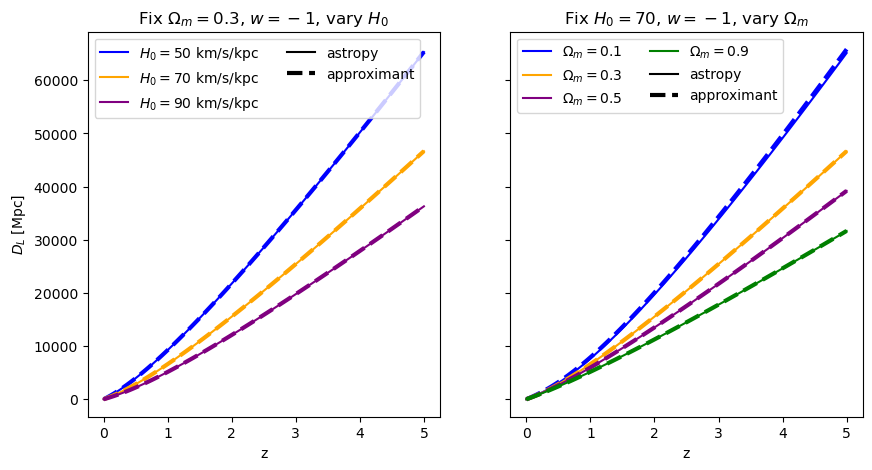

In [98]:
# luminosity distance
fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,dL_approx(z_arr,H0,0.3),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3).luminosity_distance(z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,dL_approx(z_arr,70,Om),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om).luminosity_distance(z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

for i in [0,1]:
    axes[i].set_xlabel("z")
axes[0].set_ylabel("$D_L$ [Mpc]")

Text(0, 0.5, '$\\frac{dV_c}{dz} [Mpc^3]$')

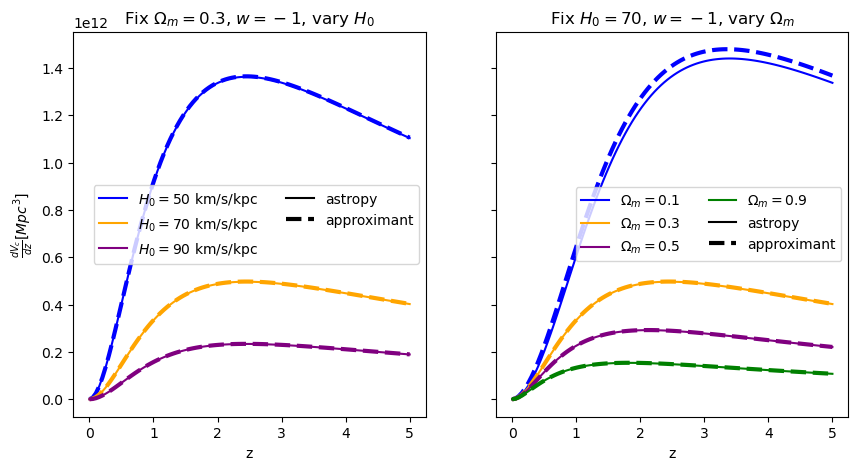

In [99]:
# differential comoving volume
fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,diff_comoving_volume_approx(z_arr,H0,0.3),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3).differential_comoving_volume(z_arr)*4*np.pi, c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,diff_comoving_volume_approx(z_arr,70,Om),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om).differential_comoving_volume(z_arr)*4*np.pi, c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

for i in [0,1]:
    axes[i].set_xlabel("z")
axes[0].set_ylabel("$\\frac{dV_c}{dz} [Mpc^3]$")

Text(0, 0.5, '$\\frac{dD_L}{dz} [Mpc]$')

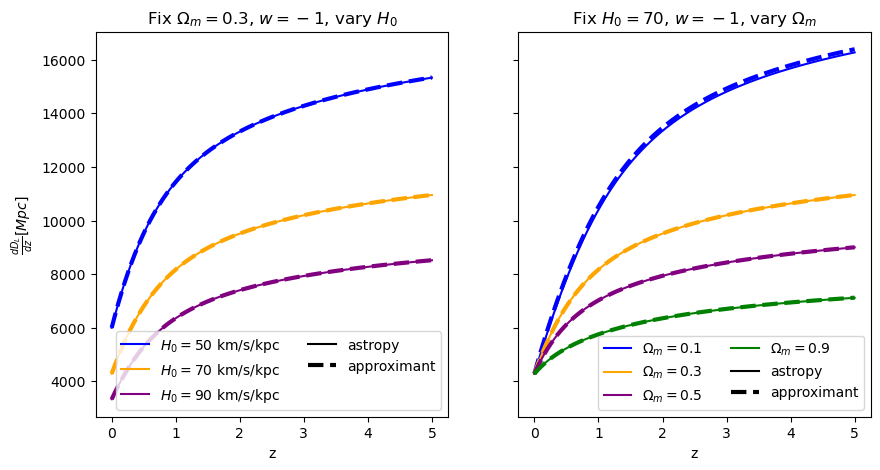

In [100]:
# Jacobian factor: ddL/dz

def dDL_dz(astropycosmo,z):
    dL = astropycosmo.luminosity_distance(z).value
    Ez_i = astropycosmo.inv_efunc(z)
    D_H = (Clight/1e3) / astropycosmo.H0.value
    return np.abs(dL/(1.+z) + (1.+z)*D_H * Ez_i)

fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,dDLdz_approx(z_arr,H0,0.3),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,dDL_dz(FlatwCDM(H0=H0,Om0=0.3),z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,dDLdz_approx(z_arr,70,Om),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,dDL_dz(FlatwCDM(H0=70,Om0=Om),z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

for i in [0,1]:
    axes[i].set_xlabel("z")
axes[0].set_ylabel("$\\frac{dD_L}{dz} [Mpc]$")

## Adapted with $w\neq-1$

The new taylor expansion is:
\begin{equation}
F = \sqrt{a} \sum_{n=0}^{\infty}{-1/2 \choose n} \frac{x^n}{1/2-3wn}
\end{equation}

In [150]:
def Phi_w(x,w=-5):
    num = 2 * (64 + 80*x + 24*x**2 + x**3 - 24 * w * (624 + 760 * x + 222*x**2 + 9*x**3) + 
    144 * w**2 * (11920 + 14560 * x + 4278*x**2 + 175*x**3) - 
    1728 * w**3 * (71672 + 87840 * x + 25791*x**2 + 1049*x**3) + 
    2592 * w**4 * (2356832 + 2882800 * x + 839268*x**2 + 33719*x**3) - 
    62208 * w**5 * (3445928 + 4201240 * x + 1212453*x**2 + 48254*x**3) + 
    313456656384 * w**12 * (3319040 + 4519200 * x + 1598688*x**2 + 
       111783*x**3) + 
    186624 * w**6 * (29448112 + 35918800 * x + 10359714*x**2 + 413179*x**3) - 
    17414258688 * w**11 * (30788544 + 38850120 * x + 11816424*x**2 + 
       495569*x**3) - 
    2239488 * w**7 * (46909544 + 57549840 * x + 16745037*x**2 + 668609*x**3) + 
    1934917632 * w**10 * (61958336 + 76676430 * x + 22483512*x**2 + 
       837203*x**3) - 
    120932352 * w**9 * (133531520 + 165267720 * x + 48520736*x**2 + 
       1828153*x**3) + 
    1679616 * w**8 * (900485632 + 1112477520 * x + 326613696*x**2 + 
       12787417*x**3))
    den = (-1 + 6 * w) * (-1 + 12 * w) * (-1 + 18 * w) * (64 + 112 * x + 56 * x**2 + 7 * x**3 - 
   12*w * (1056 + 1792 * x + 868 * x**2 + 105 * x**3) + 
   36*w**2 * (34304 + 58128 * x + 28336 * x**2 + 3479 * x**3) - 
   432*w**3 * (171968 + 288960 * x + 139552 * x**2 + 16891 * x**3) - 
   241864704*w**9 * (3319040 + 4519200 * x + 1598688 * x**2 + 111783 * x**3) + 
   1296*w**4 * (2260032 + 3729936 * x + 1763944 * x**2 + 209097 * x**3) - 
   3919104*w**7 * (4782720 + 7538144 * x + 3394704 * x**2 + 391167 * x**3) - 
   15552*w**5 * (5009056 + 8107680 * x + 3754156 * x**2 + 439439 * x**3) + 
   6718464*w**8 * (25067648 + 37946160 * x + 15870960 * x**2 + 1547889 * x**3) + 
   46656*w**6 * (30759808 + 49091504 * x + 22480304 * x**2 + 2667861 * x**3))
    return -1*num/den

def xx_w(z,Om0,w=-5):
    return (1.0-Om0)/Om0/np.power(1.0+z,-3*w)

def dL_approx_w(z,H0,Om0,w):
    D_H = (Clight/1.0e3)  / H0 #Mpc
    return D_H * (1.+z) * (Phi_w(xx_w(0.,Om0,w),w) - Phi_w(xx_w(z,Om0,w),w)/np.sqrt(1.+z))/np.sqrt(Om0)


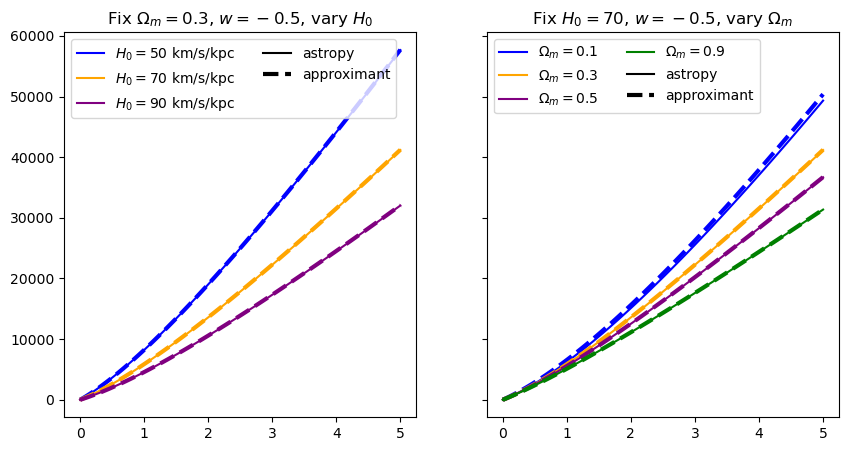

In [156]:
fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
w = -0.5
axes[0].set_title(f"Fix $\Omega_m=0.3$, $w={w}$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,dL_approx_w(z_arr,H0,0.3,w=w),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3,w0=w).luminosity_distance(z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title(f"Fix $H_0=70$, $w={w}$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,dL_approx_w(z_arr,70,Om,w=w),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om,w0=w).luminosity_distance(z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

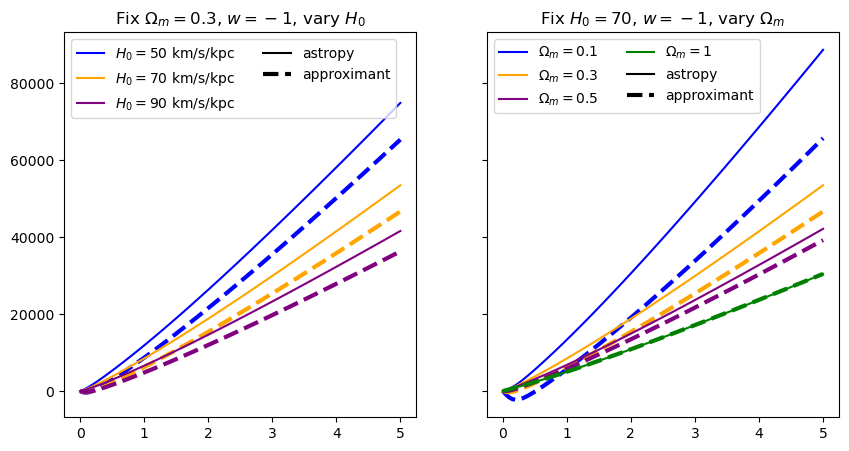

In [95]:
fig, axes = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True,figsize=(10,5))
# axis 0: vary H0
axes[0].set_title("Fix $\Omega_m=0.3$, $w=-1$, vary $H_0$")
for H0, c in zip(H0_vals,colors):
    axes[0].plot(z_arr,dL_approx(z_arr,H0,0.3),ls="--",lw=3,c=c)
    axes[0].plot(z_arr,FlatwCDM(H0=H0,Om0=0.3,w0=-5).luminosity_distance(z_arr), c=c,label=f"$H_0=${H0} km/s/kpc")
axes[0].plot([],c='k',label="astropy")
axes[0].plot([],c='k',ls="--",lw=3,label="approximant")
axes[0].legend(ncol=2)

# axis 1: vary Om0
axes[1].set_title("Fix $H_0=70$, $w=-1$, vary $\Omega_m$")
for Om, c in zip(Om_vals,colors):
    axes[1].plot(z_arr,dL_approx(z_arr,70,Om),ls="--",lw=3,c=c)
    axes[1].plot(z_arr,FlatwCDM(H0=70,Om0=Om,w0=-5).luminosity_distance(z_arr), c=c,label=f"$\Omega_m=${Om}")
axes[1].plot([],c='k',label="astropy")
axes[1].plot([],c='k',ls="--",lw=3,label="approximant")
axes[1].legend(ncol=2)

In [128]:
from scipy.interpolate import pade

In [134]:
# w=-1 case
pade([2, -1/7,3/52,-5/152,7/320,-63/3968,231/18944],3)
# output confirmed same as eqs 2.5--2.11

(poly1d([0.05312495, 0.8830444 , 2.64086441, 2.        ]),
 poly1d([0.03943821, 0.51209467, 1.39186078, 1.        ]))

2.64086441484343